In [ ]:
#Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Question of Interest

For LGD data, there are often a lot of 0% values and then a number of non-zero fractions.
For modeling this data, 2 commonly suggested techniques are Zero/One Inflated Beta Regression and Beta Regression with squished endpoints (e.g., 0 -> 0.00001).

This analysis compares the two methods under a scenario where we know the ground truth of effects on LGD.

This analysis assumes that LGDs are either zero or non-zero (and non-one) based on draws from a binomial distribution with probability (1-prob_zero). There is 1 covariate (X) that has a protective effect on LGD. For each 1 unit increase in X, there is a protective effect defined by covariate_effect (e.g., 1/12). 

The question is which method does the best job at identifying the effect under three scenarios:
1. X has no effect on the probability of 0% or non-0% LGD
2. X has the same protective effect and increases the probability that a unit has 0% LGD.
3. X has the opposite effect on whether a unit has a 0% LGD and increases the probability that LGD is > 0%.



In [41]:
#Step 1: Simulate fractional data with heavy right skew and known covariate effects
#There is likely a quicker way to simulate this, but part of the motivation for this project is to learn more python
#Parameters
sample_size = 1000
prob_zero = 0.35 #This is on average the proportion of values with 0
covariate_effect = 1/12 #X has a protective effect on LGD. For each unit of X, the LGD


#Define probability of exactly 0% value using binomial distribution
sample = np.random.binomial(n = 1, p = 1-prob_zero, size = sample_size)

#For non-zero entries, replace value with random draw from beta distribution
non_zero_n = len(sample > 0)
non_zero_sample = np.random.beta(a = 5, b = 10, size = non_zero_n)


#Modify the non-zero sample by the X coefficient
X = np.random.normal(loc = 0, scale = 1, size = non_zero_n)
non_zero_sample = non_zero_sample + covariate_effect*X

sample = np.where(sample > 0
                ,non_zero_sample
                , sample)
#Set any values that are < 0% LGD to 0% LGD and > 100% LGD to 100%.
sample = np.where(sample < 0, 0, sample)
sample = np.where(sample > 1, 1, sample)



<Axes: ylabel='Count'>

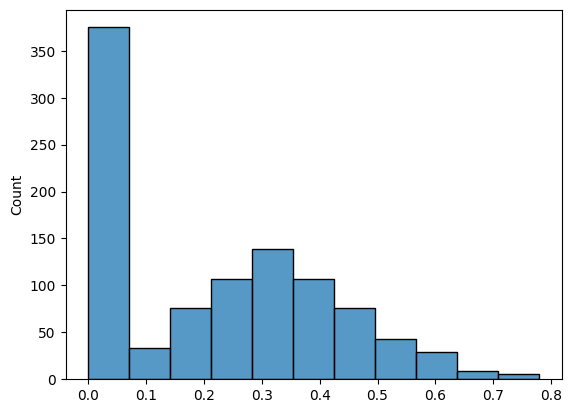

In [42]:
sns.histplot(sample)

This plot shows the skewed distribution, where there are a lot of 0% observations.

The next plot shows the distribution of covariate (X) values used to modify the effect.

<Axes: ylabel='Count'>

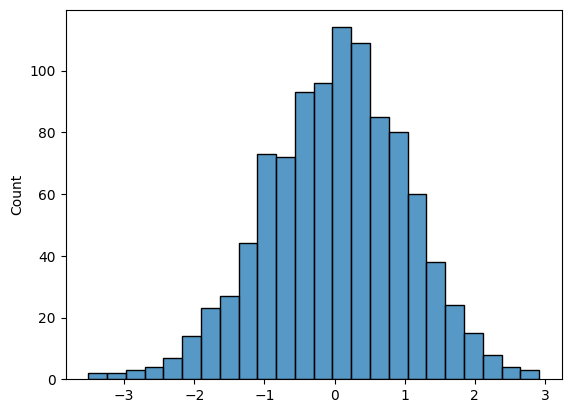

In [44]:
sns.histplot(X)

In [ ]:
#Scenario 1 Analysis

#Fit Zero-inflated Beta Regression Model + analyze

#Modify zero and 1 values to fit with just beta regression + analyze


In [ ]:
#Scenario 2 Analysis

#Resample data
#Fit models and re-analyze

In [ ]:
#Scenario 3 Analysis

#Resample data
#Fit models and re-analyze